In [12]:
#Import the necessary tools for the computation
import numpy as np
import random
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute,Aer
from qiskit import IBMQ
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
barriers = True

In [13]:
#Make sure to execute this command at least once before you try to connect to the hardware backend.
#If you have trouble please consult lecture 2, the online QISKit documentation, or contact us.
IBMQ.load_account()

C:\Users\Parth\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### In this notebook, you will mimic Google's quantum supremacy experiment by constructing a random quantum circuit and running it on simulators as well as IBM's hardware backend.

### Use 12 qubits. Your circuit depth for this project will be measured in cycles where each cycle corresponds to a round of single qubit gates followed by a round of CZs.

### In each cycle, choose a random single qubit gate for each qubit using U3. Randomly choose these via a seed, so you can easily reproduce the random sequence. U3 takes 3 parameters which you should choose as follows: 

### $\theta = 2 \cos^{-1} (\text{r.random()})$
### $\lambda = 2 \pi * \text{r.random()}$
### $\phi = 2 \pi * \text{r.random()}$

### After applying the single qubit gates, apply the appropriate CZ gates according to the following pattern:
### On even cycles CZ nearest neighbor qubits such as 0-1,  2-3,  4-5,  6-7,  8-9,  10-11
### On odd cycles CZ qubits which are $\frac{n}{2}$ away from one another such as 0-6,  1-7,...
### Repeat

### Do this for circuit depths ranging from 1 cycle to 12 cycles. For each random circuit, make a record of the random number sequence which was used to generate the gates.

### Run your circuit on the statevector simulator as the ideal classical simulation. Note that for the statevector simulator, you should not include the measurement gates in your circuit. 
### Then run it on the qasm simulator and the hardware backend in order to get measurement frequencies.

### Once you have the probabilities and frequencies, you will be calculating the linear cross entropy fidelity, $\mathscr{F}_{XEB}$ of your run. At each depth, do all of this for at least 2 different random circuit realizations on both the qasm simulator and the hardware.

In [14]:
n=12

#### When a random seed is set, random numbers can be generated in a sequence which will be exactly duplicated each time the same seed is used. Therefore, the following cell which sets the random seed should be executed before each NEW depth circuit. But it should not be executed between DIFFERENT circuits of the same depth. 

In [358]:
#This cell allows you to set a seed for your random number generation.
#By using the same seed, you can repeatedly generate the same random sequence.
#Take advantage of this in order to test the same random ciruit on multiple backends.

#This cell should be executed
r = random.Random()
r.seed('14')
#seed1: 'plant seed here' - depth = 4
#seet2: '11' - depth = 5
#seed3: '12' - depth = 6
#seed4: '13' - depth = 7
#seed5: '14' - depth = 3
#seed6: '15' - depth = 2
#seed7: '16' - depth = 1

In [371]:
q=QuantumRegister(n)
c=ClassicalRegister(n)
qc=QuantumCircuit(q,c)

In [372]:
# 1st choose the depth of your current run
depth = 3
def barrier(qc):
    if barrier:
        qc.barrier()
# Then construct your circuit
for i in range(depth):
    #Put the single qubit gates here
    #set_trace()
    qc.u3(2 * np.arccos(r.random()), 2 * np.pi * r.random(), 2 * np.pi * r.random(), q[i])

    #Put the CZs here
    if i % 2 == 0:
        qc.cz(q[i], q[i+1])
    elif i % 2 == 1:
        qc.cz(q[i], q[i+int((n/2))])

    #These barriers separate each cycle
    qc.barrier()
    #barrier(qc)

In [238]:
qc.measure(q,c)

### The following cells select which backend runs your quantum circuit. Only execute the desired commands.
#### If you have trouble with the backends, reference lecture 2, the QISKit documentation, and/or ask us for help.

Choose a backend

In [373]:
#In order for this to work, there must be no measurement gates in your circuit (or simply don't execute them)
backend = Aer.get_backend('statevector_simulator')

In [206]:
backend = Aer.get_backend('qasm_simulator')

In [379]:
provider = IBMQ.get_provider(group='open')
backend=provider.get_backend('ibmq_16_melbourne')

Run the job

In [374]:
#Notice the high shot count
job = execute(qc, backend, shots=8192)

In [380]:
job = backend.retrieve_job('5da7af8c43fe7b0011dcde83')

In [381]:
result = job.result()

Save your results

In [ ]:
#Choose one of these!

In [376]:
statevec=result.get_statevector(qc)

In [382]:
counts=result.get_counts()

### Save your frequency/probability data from your runs, and use them to calculate the linear cross entropy fidelity for the qasm simulator and the actual hardware at each circuit depth.

### In order to retrieve your results from IBM's hardware, you have a few options. When you submit a job to the hardware backend, your job will enter a queue which means you will have to wait. You can either submit this job from your local jupyter notebook the way we have previously discussed, or you can run your codes on the IBM quantum experience website's provided jupyter notebooks. If running online, you can retrieve results just like you would with the qasm simulator only with a long wait for the job. If you submit from your local machine, you can find the results page on the website. From the results page, download the .json file. This file will contain, among other things, the counts data which you can import, save into a new file, or copy and paste into your notebook.

### IMPORTANT: Your $\mathscr{F}_{XEB}$ falling outside of  $\left[0,1\right]$ does not necessarily mean it is incorrect

In [256]:
#Generate a list of all the possible binary outputs
BL=[] #Binary List - list of binary numbers from 0 to 2**n-1
for i in range(2**n):
    BL.append(bin(i)[2:].zfill(n))

In [257]:
#From the output of the qasm simulation, convert counts to frequencies and save to a list 
# which matches up with the list of binaries, BL
fout=[] #frequencies of outputs
totalshots=sum(counts.values())
for i in BL:
    if i in counts.keys():
        fout.append(counts[i]/totalshots)
    else:
        fout.append(0)

In [377]:
#statevec will contain the probability amplitude for each possible binary string, so we convert them to probabilities
probabilities=statevec*statevec.conjugate()

### Reminder: $\mathscr{F}_{XEB}=2^{n}\langle P(x)\rangle-1=2^{n} \sum_{x} P(x)f(x) -1$

In [258]:
#Write a function which takes the frequencies and probabilities as input and outputs the linear cross entropy fidelity
def FXEB(fout, probabilities):
    expectation = 0
    for i,j in zip(fout, probabilities):
        result = i*j
        expectation += result
    fxeb = (2**n) * expectation - 1
    return fxeb

In [370]:
trial1 = FXEB(fout,probabilities)

In [383]:
trial2 = FXEB(fout, probabilities)

In [43]:
sim_fidelity = [] #run only once

In [212]:
average = (trial1 + trial2)/2
sim_fidelity.append([average, depth])
#sim_fidelity.insert(0, [average, depth])

In [213]:
for i in sim_fidelity:
    print(i)

[(2231.6655943324554+0j), 1]
[(1856.6027632548103+0j), 2]
[(1055.1137825580079+0j), 3]
[(1273.9566840411258+0j), 4]
[(486.48603779846115+0j), 5]
[(217.35930327618746+0j), 6]
[(128.18413319632734+0j), 7]


In [260]:
hardware_fidelity = [] #run only once

In [ ]:
#depth 4
#backend.retrieve_job('5da42d03743a6b001814c214')
#depth 5
#backend.retrieve_job('5da561f4beb3350011051277') #trial 1
#backend.retrieve_job('5da5ce923c1181001284dbf1') #trial 2
#depth 6 
#backend.retrieve_job('5da5e4a643fe7b0011dcce17') #trial 1
#backend.retrieve_job('5da5e82de31238001199b633') #trial 2
#depth 7
#backend.retrieve_job('5da5e8c540a83b0011988256') #trial 1
#backend.retrieve_job('5da5ecfc4ce7bf0011aacd68') #trial 2
#depth 3 
#backend.retrieve_job('5da7ad993c1181001284ee02') #trial 1
backend.retrieve_job('5da7af8c43fe7b0011dcde83') #trial 2

In [388]:
average = (trial1 + trial2)/2
#average = trial1
#hardware_fidelity.append([average, depth])
hardware_fidelity.insert(0, [average, depth])

In [389]:
for i in hardware_fidelity:
    print(i)

[(1.1139395313028067+0j), 3]
[(-0.9057214437256331+0j), 4]
[(4.564671032102008+0j), 5]
[(14.316033130776555+0j), 6]
[(5.374858009534344+0j), 7]


#### Make sure to save your calculated $\mathscr{F}_{XEB}$ for each run of each circuit depth before you run a new circuit

### Plot $\mathscr{F}_{XEB}$ vs circuit depth for the qasm simulator and hardware backends on the same graph.
#### For each backend, your 2 (or more) values of $\mathscr{F}_{XEB}$ for each depth can be averaged together, plotted separately, or both.

C:\Users\Parth\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


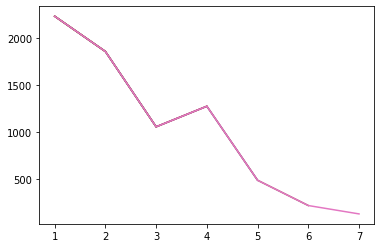

In [214]:
y = []
x = []
for i in range(len(sim_fidelity)):
    y.append(sim_fidelity[i][0])
    x.append(sim_fidelity[i][1])
    plt.plot(x,y)

C:\Users\Parth\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


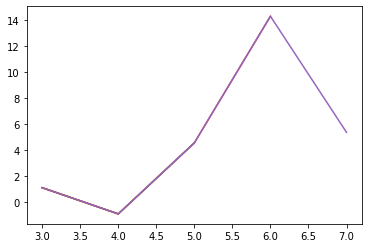

In [390]:
y = []
x = []
for i in range(len(hardware_fidelity)):
    y.append(hardware_fidelity[i][0])
    x.append(hardware_fidelity[i][1])
    plt.plot(x,y)

### Comment on  trends in the $\mathscr{F}_{XEB}$ vs depth plot.

In [391]:
#The trends between the sim_fxeb plot vs depth are decreasing while the trend between the hardware_fxeb vs depth are increasing. 